# **Homework 5**  
**Date:** 17/12/2024  

## **Introduction**  
In this exercise, we will obtain data from the internet by REST APIs and Web Scraping.


---

## **Contents**  
1. **REST API**  
   1.1 Using the API  
   1.2 Data Cleaning  
   1.3 Creating and displaying the wordcloud

2. **Web Scraping**   
   2.1 Creating function to get url for page number   
   2.2 Creating function to get book data    
   2.3 Creating and displaying the data    




## 1. REST API 

We will interact with the Nobel Prize API to retrieve Nobel Prize information in Physics. We will then focus on extracting the prize motivations and visualize them using a word cloud.

### 1.1 Using the API

In [1]:
import requests
import json
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# Fetch Nobel Prize data in Physics
API_URL = "https://api.nobelprize.org/2/nobelPrizes?nobelPrizeCategory=phy"
response = requests.get(API_URL)
data = response.json() 

# Extracts all motivations
motivations = []
for prize in data.get('nobelPrizes', []):
    # If each prize has multiple laureates
    laureates = prize.get('laureates', [])
    for laureate in laureates:
        motivation = laureate.get('motivation', {}).get('en', "")
        if motivation:
            motivations.append(motivation)
# Data inspection
motivations[:3]

['in recognition of the extraordinary services he has rendered by the discovery of the remarkable rays subsequently named after him',
 'in recognition of the extraordinary service they rendered by their researches into the influence of magnetism upon radiation phenomena',
 'in recognition of the extraordinary service they rendered by their researches into the influence of magnetism upon radiation phenomena']

### 1.2 Data cleaning

In [2]:
# Combine all motivations into a single string
all_text = " ".join(motivations)

# Capitalize all words
all_text = all_text.title()

# Remove punctuation with regex
all_text = re.sub(r'[^\w\s]', '', all_text)

# Splitting on whitespace
words = all_text.split()

# Remove stopwords
stop_words = set(stopwords.words('english'))
clean_words = [word for word in words if word not in stop_words]

clean_text = " ".join(clean_words)

### 1.3 Creating and displaying the wordcloud

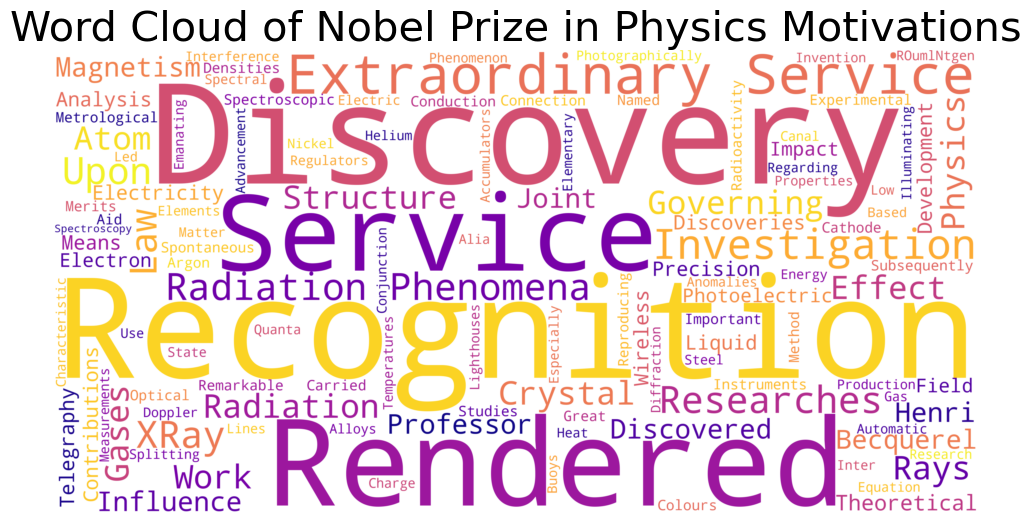

In [3]:
# Creating wordcloud
wordcloud = WordCloud(width=4000, height=2000, colormap='plasma', background_color='white').generate(clean_text)

# Show wordcloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Nobel Prize in Physics Motivations", fontsize=30)
plt.show()

## 2. Web Scraping 

We will scrape the site (https://books.toscrape.com/) and collect data on books, including their UPC, title, price, and rating. We will scrape 3 pages and put together the data into a structured format. Finally we'll show the final table. 

In [4]:
import requests
from bs4 import BeautifulSoup

BASE_URL = "https://books.toscrape.com/"

### 2.1 Creating function to get url for page number

In [5]:
PAGE_URL = BASE_URL + "catalogue/page-{}.html"
def get_book_links(page_number):
    """
    From given page number
    Returns list: Absolute URLs of books listed on the page.
     """
    url = PAGE_URL.format(page_number)
    r = requests.get(url)
    soup = BeautifulSoup(r.content, "html.parser")
    # Books are listed under article.product_pod
    books = soup.find_all("article", class_="product_pod")
    links = []
    for book in books:
        # Each book link is in h3 > a, with a href value
        href = book.find("h3").find("a")["href"]
        # Make the link absolute
        link = BASE_URL + "catalogue/" + href
        links.append(link)
    return links

### 2.2 Creating function to get book data

In [6]:
def get_book_data(book_url):
    """
    From the given book page URL
    Returns dict: 'upc', 'title', 'price', and 'rating' of the book
    """
    r = requests.get(book_url)
    soup = BeautifulSoup(r.content, "html.parser")
    
    # Title at h1
    title = soup.find("h1").get_text(strip=True)
    # Price
    price = soup.find("p", class_="price_color").get_text(strip=True)
    # Ratings in second element
    rating = soup.find("p", class_="star-rating")["class"][1]
    # UPC is in a table 
    table = soup.find("table", class_="table-striped")
    upc = table.find("th", string="UPC").find_next_sibling("td").get_text(strip=True)
    
    return {"upc": upc, "title": title, "price": price, "rating": rating}

### 2.3 Creating and displaying the data

In [7]:
all_data = []
# We will scrape first three pages
for page in range(1, 4):
    book_links = get_book_links(page)
    for link in book_links:
        book_info = get_book_data(link)
        all_data.append(book_info)
        
df_books = pd.DataFrame(all_data)
df_books.head(5)

,upc,title,price,rating
0,a897fe39b1053632,A Light in the Attic,£51.77,Three
1,90fa61229261140a,Tipping the Velvet,£53.74,One
2,6957f44c3847a760,Soumission,£50.10,One
3,e00eb4fd7b871a48,Sharp Objects,£47.82,Four
4,4165285e1663650f,Sapiens: A Brief History of Humankind,£54.23,Five
